In [177]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
import pandas as pd

In [178]:
# Hyperparameters
cuda = True
epochs = 20
log_interval = 400
batchSize = 16

hidden_layer_size = 20

lr = 0.001

In [179]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        activation_1 = F.relu(self.fc1(x))
        x = self.fc2(activation_1)
        return x, torch.sign(activation_1)
    
model = Net()
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Net (
  (fc1): Linear (3072 -> 20)
  (fc2): Linear (20 -> 10)
)


In [180]:
class ActivationFollower():
    
    train_activations = 0
    train_labels = 0
    test_activations = 0
    test_labels = 0
    
    def __init__(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def reset(self):
        train_activations = 0
        train_labels = 0
        test_activations = 0
        test_labels = 0
    
    def train_add(self, x, y):
        if type(self.train_activations) is np.ndarray:
            self.train_activations = np.append(self.train_activations, x, axis=0)
            self.train_labels = np.append(self.train_labels, y, axis=0)
        else:
            self.train_activations = x
            self.train_labels = y
    
    def test_add(self, x, y):
        if type(self.test_activations) is np.ndarray:
            self.test_activations = np.append(self.test_activations, x, axis=0)
            self.test_labels = np.append(self.test_labels, y, axis=0)
        else:
            self.test_activations = x
            self.test_labels = y
        
    def print_metrics(self):
        elems = 1000
        bins = range(0, hidden_layer_size)
        indexes1 = np.random.choice(self.train_activations.shape[0], 20000)
        indexes2 = np.random.choice(self.train_activations.shape[0], 20000)
        
        distances = np.abs(self.train_activations[indexes1] - self.train_activations[indexes2]).sum(1)
        distances = np.append(distances.reshape(-1,1), self.train_labels[indexes1].reshape(-1,1), axis=1)
        distances = np.append(distances, self.train_labels[indexes2].reshape(-1,1), axis=1)
        ordered_distances = np.copy(distances)
        ordered_distances[:,1] = np.min(distances[:,[1,2]], axis=1)
        ordered_distances[:,2] = np.max(distances[:,[1,2]], axis=1)
        df_mean = pd.DataFrame(ordered_distances)
        df_mean = df_mean.groupby([1, 2])[0].mean()
        df_std = pd.DataFrame(ordered_distances)
        df_std = df_std.groupby([1, 2])[0].std()
        
        means = [[0 for i in range(10)] for j in range(10)]
        stds = [[0 for i in range(10)] for j in range(10)]
        for i in df_mean.index.values:
            if i[0] != i[1]:
                means[int(i[0])][int(i[1])] = df_mean[i]
                means[int(i[1])][int(i[0])] = df_mean[i]
                
                stds[int(i[0])][int(i[1])] = df_std[i]
                stds[int(i[1])][int(i[0])] = df_std[i]
            else:
                means[int(i[0])][int(i[1])] = df_mean[i]
                stds[int(i[0])][int(i[1])] = df_std[i]
        
        
        # Plot it out
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        heatmap = ax1.pcolor(means, cmap=plt.cm.Blues, alpha=0.8)

        # Format
        fig = plt.gcf()
        fig.set_size_inches(20, 5)

        # turn off the frame
        ax1.set_frame_on(False)

        # put the major ticks at the middle of each cell
        ax1.set_yticks(np.arange(10) + 0.5, minor=False)
        ax1.set_xticks(np.arange(10) + 0.5, minor=False)

        # want a more natural, table-like display
        ax1.invert_yaxis()
        ax1.xaxis.tick_top()

        # Set the labels

        # label source:https://en.wikipedia.org/wiki/Basketball_statistics
        labels = ['plane', 'car', 'bird', 'cat', 
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        # note I could have used nba_sort.columns but made "labels" instead
        ax1.set_xticklabels(labels, minor=False)
        ax1.set_yticklabels(labels, minor=False)

        # rotate the
        plt.xticks(rotation=90)

        ax1.grid(False)

        # Turn off all the ticks
        ax1 = plt.gca()
        for t in ax1.xaxis.get_major_ticks():
            t.tick1On = False
            t.tick2On = False
        for t in ax1.yaxis.get_major_ticks():
            t.tick1On = False
            t.tick2On = False
            
        
        #legend
        cbar = plt.colorbar(heatmap)
        cbar.set_label('Mean Distance', rotation=270)
        
        heatmap = ax1.pcolor(stds, cmap=plt.cm.Reds, alpha=0.8)

        # turn off the frame
        ax2.set_frame_on(False)

        # put the major ticks at the middle of each cell
        ax2.set_yticks(np.arange(10) + 0.5, minor=False)
        ax2.set_xticks(np.arange(10) + 0.5, minor=False)

        # want a more natural, table-like display
        ax2.invert_yaxis()
        ax2.xaxis.tick_top()

        # Set the labels

        labels = ['plane', 'car', 'bird', 'cat', 
                  'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        # note I could have used nba_sort.columns but made "labels" instead
        ax2.set_xticklabels(labels, minor=False)
        ax2.set_yticklabels(labels, minor=False)

        # rotate the
        plt.xticks(rotation=90)

        ax2.grid(False)

        # Turn off all the ticks
        ax2 = plt.gca()
        for t in ax2.xaxis.get_major_ticks():
            t.tick1On = False
            t.tick2On = False
        for t in ax2.yaxis.get_major_ticks():
            t.tick1On = False
            t.tick2On = False
            
        
        #legend
        cbar = plt.colorbar(heatmap)
        cbar.set_label('Std Distance', rotation=270)
        
        plt.show()

        # Here sample and compute histogram of distances.
        # Then Matrix with std of distances between classes.
        

In [181]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [182]:
if cuda:
    model.cuda()
    criterion.cuda()

In [183]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output, activations = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in testloader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output, activations = model(data)
        test_loss += criterion(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(testloader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
def activation_metrics():
    metrics = ActivationFollower()
    for batch_idx, (data, target) in enumerate(trainloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.train_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
    for batch_idx, (data, target) in enumerate(testloader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output, activations = model(data)
        metrics.test_add(activations.cpu().data.numpy(), target.cpu().data.numpy())
        
    metrics.print_metrics()

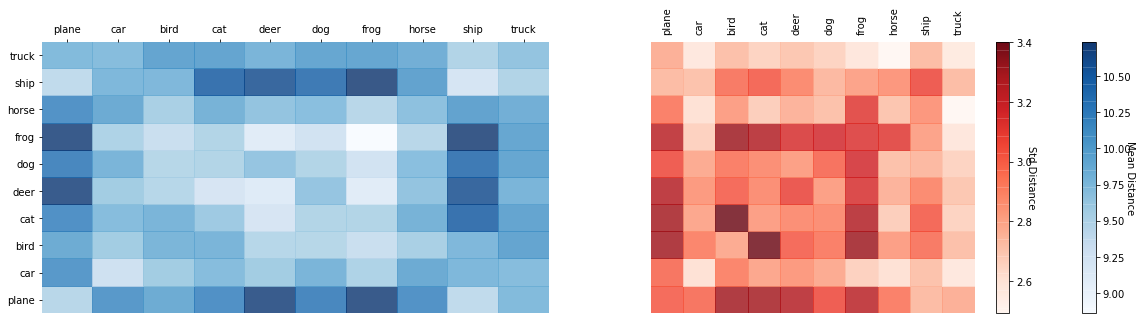

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.357293
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.915299
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.875699
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.651444
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.637894
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.079332
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.741710
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.756565

Test set: Average loss: 1.6402, Accuracy: 4232/10000 (42%)



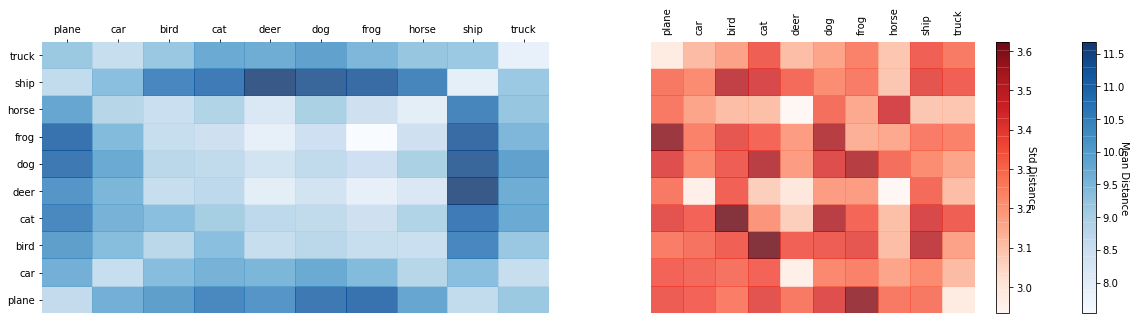

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.241114
Train Epoch: 2 [6400/50000 (13%)]	Loss: 2.095267
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.778198
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.681120
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.609852
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.500082
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.530216
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.573359

Test set: Average loss: 1.5903, Accuracy: 4397/10000 (44%)



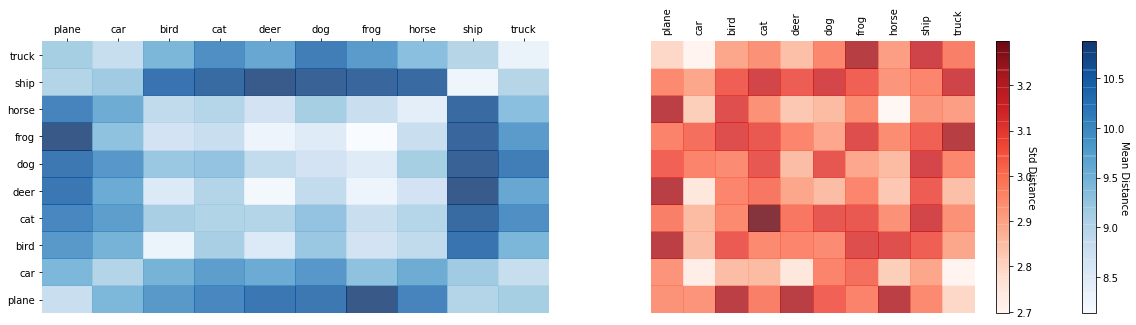

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.403326
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.756231
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.783454
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.878624
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.346867
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.538904
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.639481
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.747072

Test set: Average loss: 1.5603, Accuracy: 4465/10000 (45%)



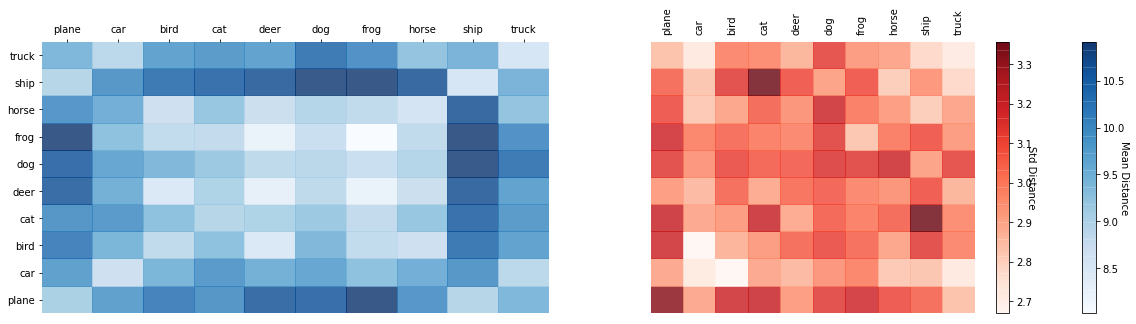

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.557553
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.845637
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.823637
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.401000
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.801617
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.225292
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.408057
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.826857

Test set: Average loss: 1.5460, Accuracy: 4574/10000 (46%)



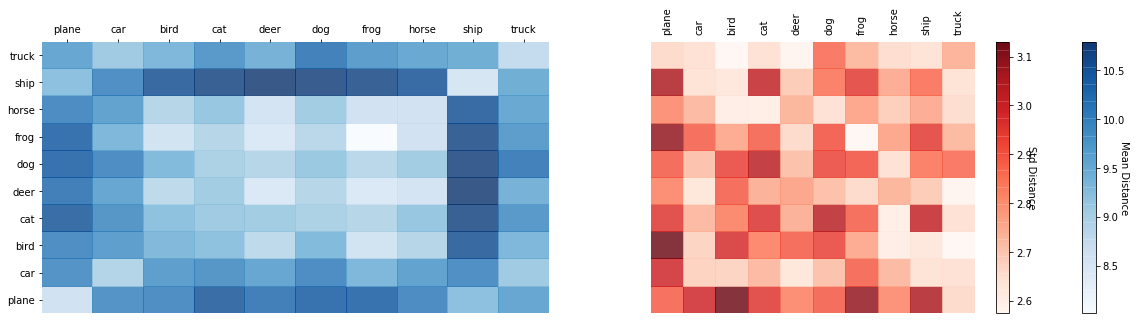

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.332802
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.586770
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.520447
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.406894
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.783463
Train Epoch: 5 [32000/50000 (64%)]	Loss: 2.059932
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.198714
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.439966

Test set: Average loss: 1.5351, Accuracy: 4563/10000 (46%)



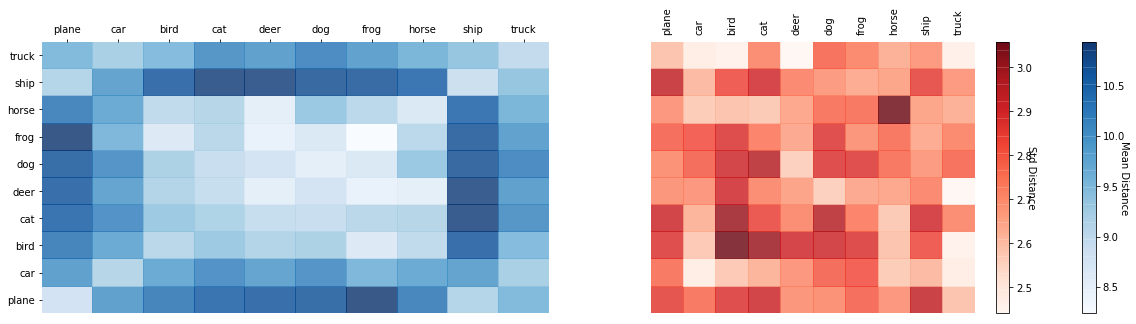

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.421287
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.265064
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.293453
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.256120
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.975017
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.809301
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.407704
Train Epoch: 6 [44800/50000 (90%)]	Loss: 1.431557

Test set: Average loss: 1.5379, Accuracy: 4601/10000 (46%)



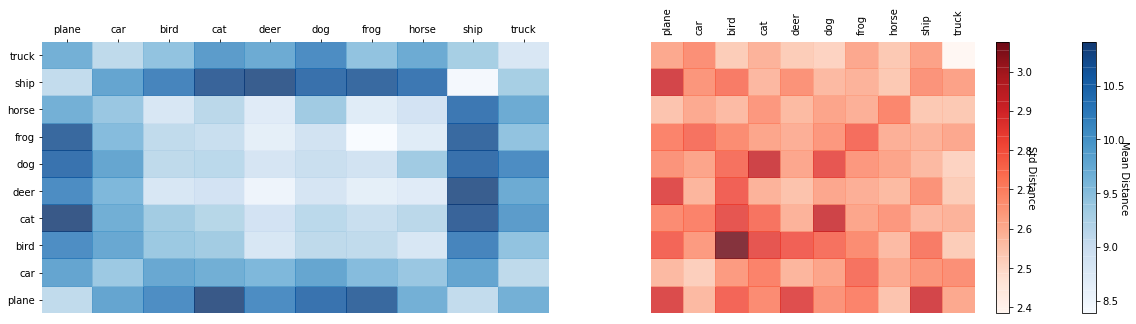

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.220809
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.429024
Train Epoch: 7 [12800/50000 (26%)]	Loss: 1.722929
Train Epoch: 7 [19200/50000 (38%)]	Loss: 2.158645
Train Epoch: 7 [25600/50000 (51%)]	Loss: 1.295088
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.605038
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.372815
Train Epoch: 7 [44800/50000 (90%)]	Loss: 1.366422

Test set: Average loss: 1.5169, Accuracy: 4606/10000 (46%)



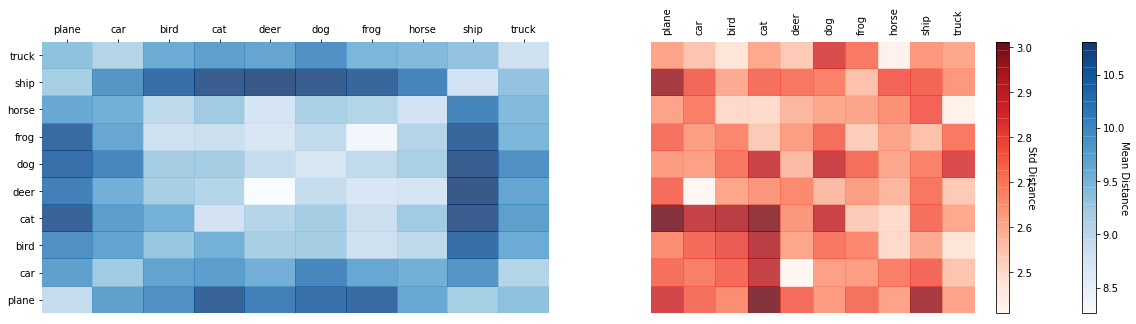

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.219276
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.641470
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.320000
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.474269
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.543892
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.749633
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.601206
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.743018

Test set: Average loss: 1.5187, Accuracy: 4612/10000 (46%)



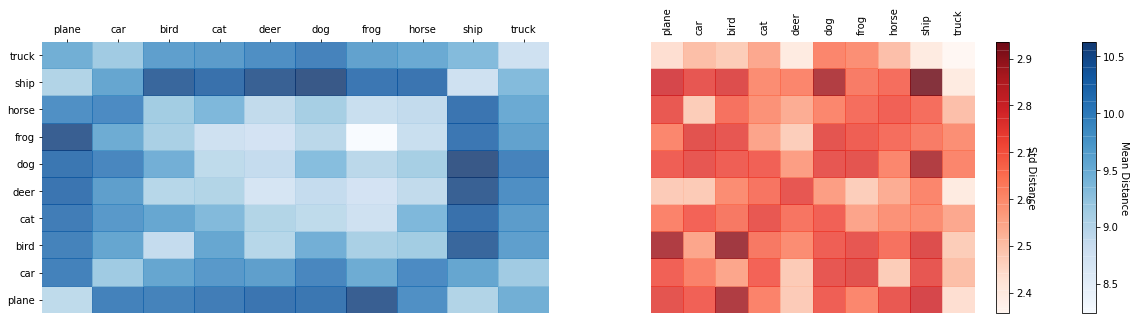

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.895792
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.792664
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.265364
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.144957
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.531720
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.537473
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.355714
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.098474

Test set: Average loss: 1.5343, Accuracy: 4607/10000 (46%)



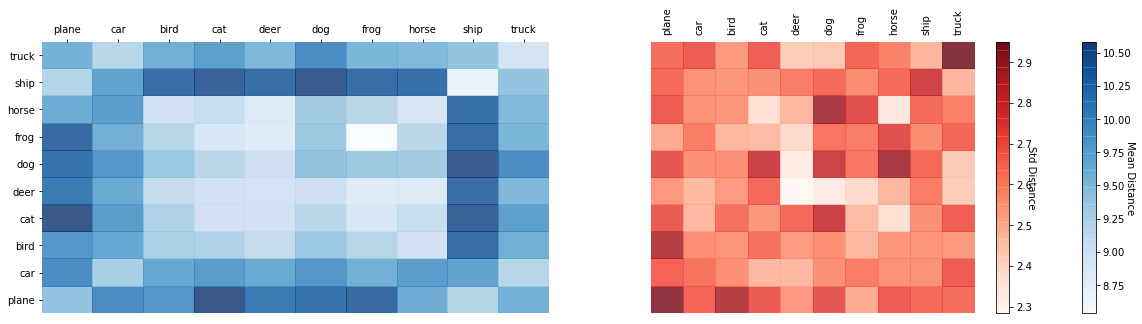

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.312016
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.276602
Train Epoch: 10 [12800/50000 (26%)]	Loss: 1.159526
Train Epoch: 10 [19200/50000 (38%)]	Loss: 1.213188
Train Epoch: 10 [25600/50000 (51%)]	Loss: 1.550660
Train Epoch: 10 [32000/50000 (64%)]	Loss: 1.309657
Train Epoch: 10 [38400/50000 (77%)]	Loss: 1.385475
Train Epoch: 10 [44800/50000 (90%)]	Loss: 1.455304

Test set: Average loss: 1.5084, Accuracy: 4714/10000 (47%)



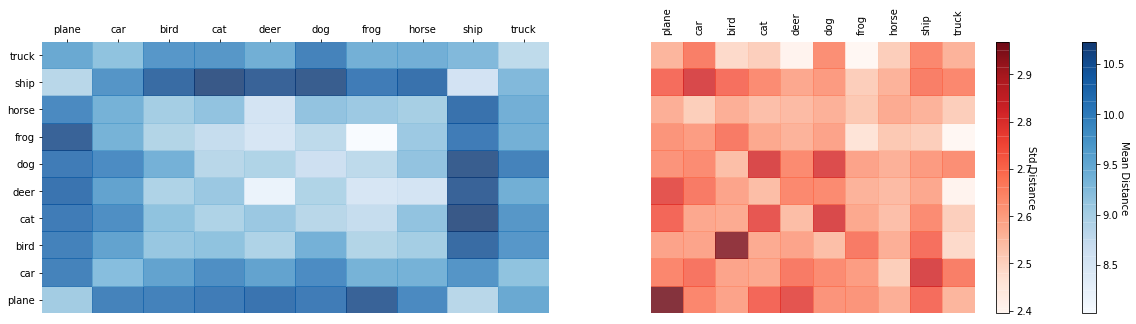

Train Epoch: 11 [0/50000 (0%)]	Loss: 1.229018
Train Epoch: 11 [6400/50000 (13%)]	Loss: 1.077516
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.853571
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.624012
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.445153
Train Epoch: 11 [32000/50000 (64%)]	Loss: 1.146752
Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.401389
Train Epoch: 11 [44800/50000 (90%)]	Loss: 1.855743

Test set: Average loss: 1.5206, Accuracy: 4646/10000 (46%)



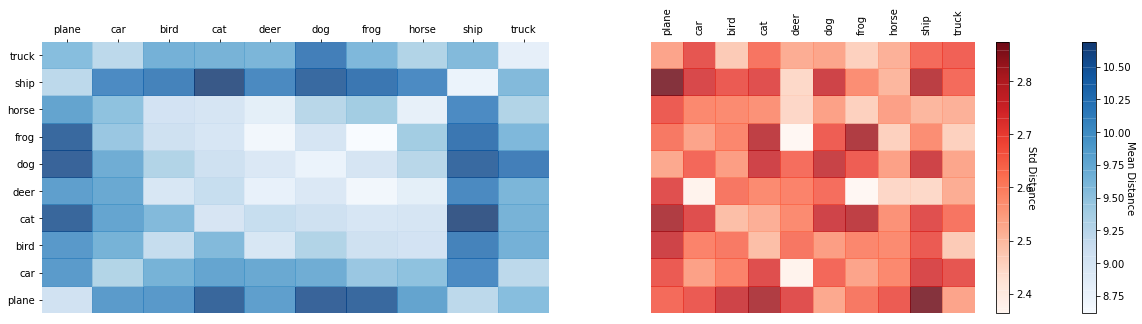

Train Epoch: 12 [0/50000 (0%)]	Loss: 1.050565
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1.401022
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.116469
Train Epoch: 12 [19200/50000 (38%)]	Loss: 1.386004
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.149382
Train Epoch: 12 [32000/50000 (64%)]	Loss: 1.540150
Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.527281
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.515492

Test set: Average loss: 1.5532, Accuracy: 4552/10000 (46%)



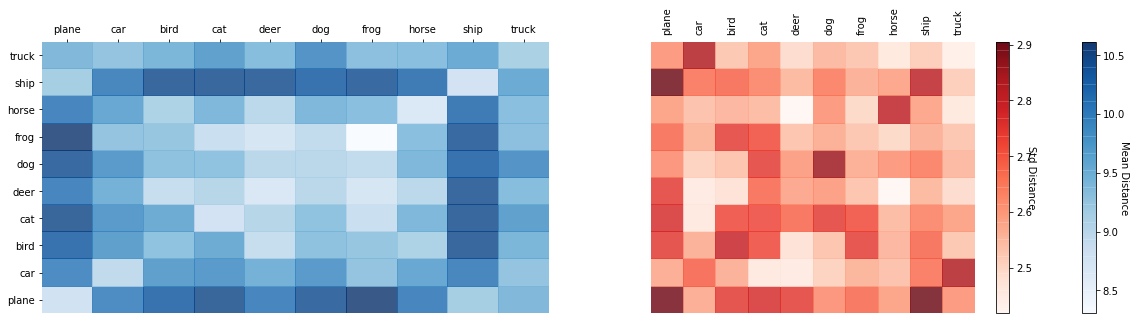

Train Epoch: 13 [0/50000 (0%)]	Loss: 1.330667
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.536756
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.601854
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.231282
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.439336
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.447763
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.026057
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.770665

Test set: Average loss: 1.5198, Accuracy: 4597/10000 (46%)



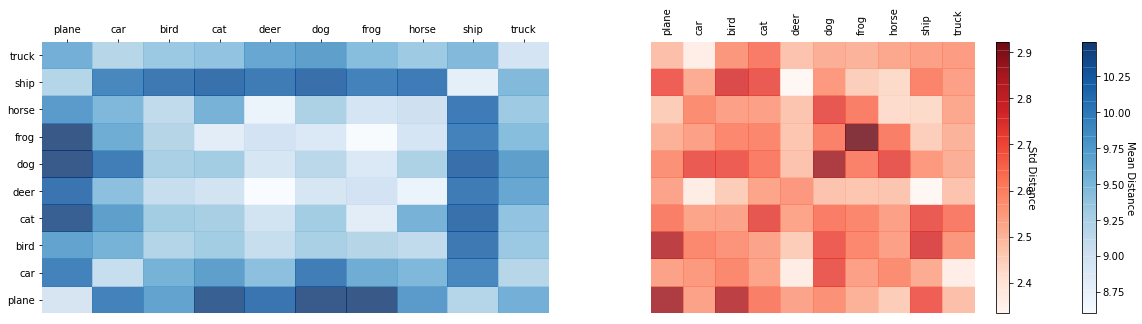

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.906387
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.671354
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.711995
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.444935
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.214655
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.430697
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.347793
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.716987

Test set: Average loss: 1.5476, Accuracy: 4506/10000 (45%)



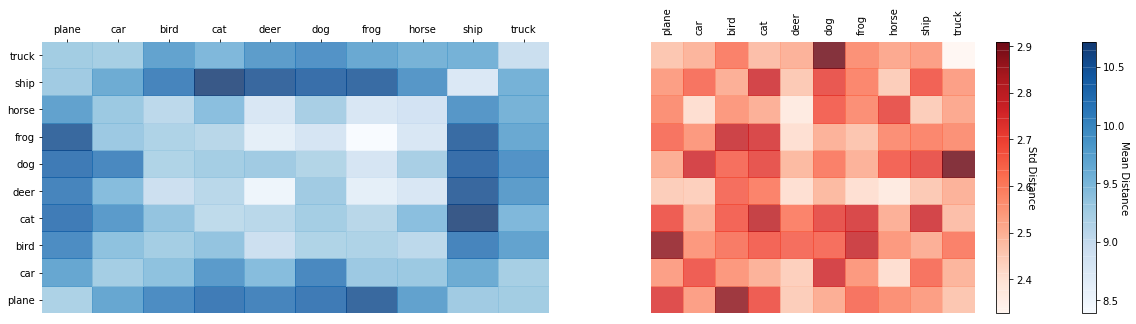

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.150300
Train Epoch: 15 [6400/50000 (13%)]	Loss: 1.015410
Train Epoch: 15 [12800/50000 (26%)]	Loss: 1.558207
Train Epoch: 15 [19200/50000 (38%)]	Loss: 1.362571
Train Epoch: 15 [25600/50000 (51%)]	Loss: 1.117427
Train Epoch: 15 [32000/50000 (64%)]	Loss: 1.473968
Train Epoch: 15 [38400/50000 (77%)]	Loss: 1.475317
Train Epoch: 15 [44800/50000 (90%)]	Loss: 1.238959

Test set: Average loss: 1.5335, Accuracy: 4600/10000 (46%)



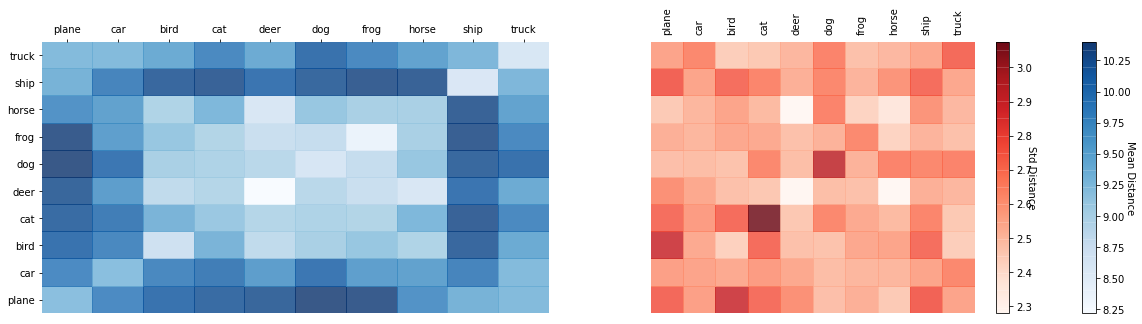

Train Epoch: 16 [0/50000 (0%)]	Loss: 1.714518
Train Epoch: 16 [6400/50000 (13%)]	Loss: 1.187471
Train Epoch: 16 [12800/50000 (26%)]	Loss: 1.571030
Train Epoch: 16 [19200/50000 (38%)]	Loss: 1.225854
Train Epoch: 16 [25600/50000 (51%)]	Loss: 1.297556
Train Epoch: 16 [32000/50000 (64%)]	Loss: 1.820584
Train Epoch: 16 [38400/50000 (77%)]	Loss: 1.818058
Train Epoch: 16 [44800/50000 (90%)]	Loss: 1.452455

Test set: Average loss: 1.5172, Accuracy: 4684/10000 (47%)



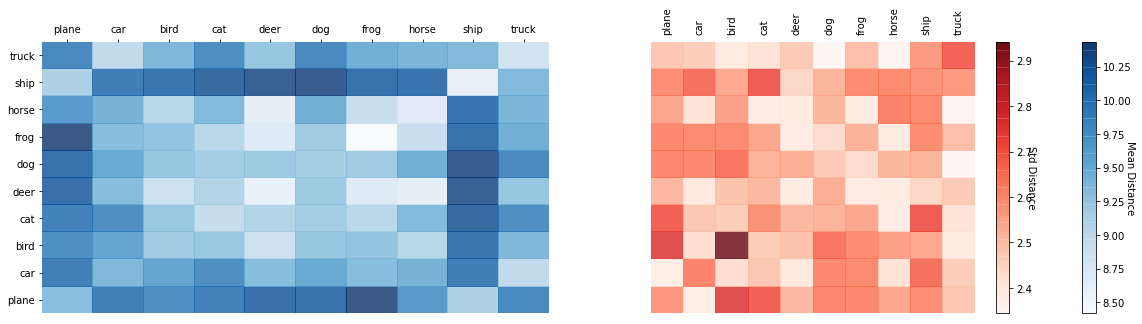

Train Epoch: 17 [0/50000 (0%)]	Loss: 1.190964
Train Epoch: 17 [6400/50000 (13%)]	Loss: 1.146039
Train Epoch: 17 [12800/50000 (26%)]	Loss: 1.131172
Train Epoch: 17 [19200/50000 (38%)]	Loss: 2.104130
Train Epoch: 17 [25600/50000 (51%)]	Loss: 1.355104
Train Epoch: 17 [32000/50000 (64%)]	Loss: 1.783018
Train Epoch: 17 [38400/50000 (77%)]	Loss: 1.479726
Train Epoch: 17 [44800/50000 (90%)]	Loss: 0.983960

Test set: Average loss: 1.5289, Accuracy: 4611/10000 (46%)



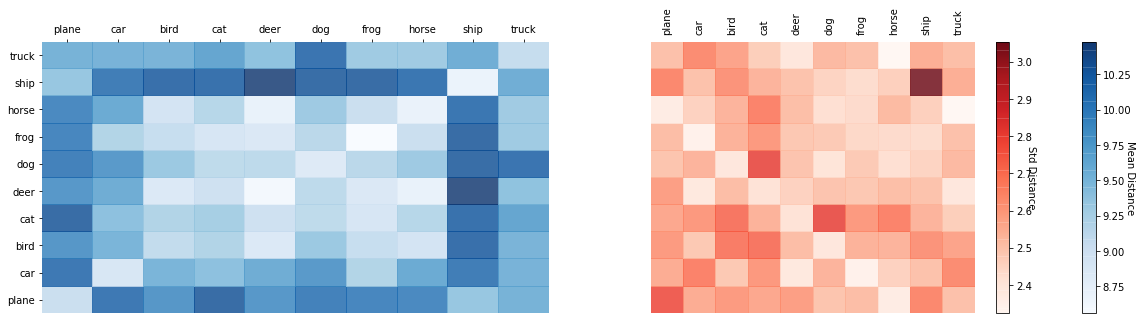

Train Epoch: 18 [0/50000 (0%)]	Loss: 1.323281
Train Epoch: 18 [6400/50000 (13%)]	Loss: 1.310468
Train Epoch: 18 [12800/50000 (26%)]	Loss: 1.196840
Train Epoch: 18 [19200/50000 (38%)]	Loss: 1.475384
Train Epoch: 18 [25600/50000 (51%)]	Loss: 1.568412
Train Epoch: 18 [32000/50000 (64%)]	Loss: 1.162130
Train Epoch: 18 [38400/50000 (77%)]	Loss: 1.554374
Train Epoch: 18 [44800/50000 (90%)]	Loss: 1.172738

Test set: Average loss: 1.5345, Accuracy: 4612/10000 (46%)



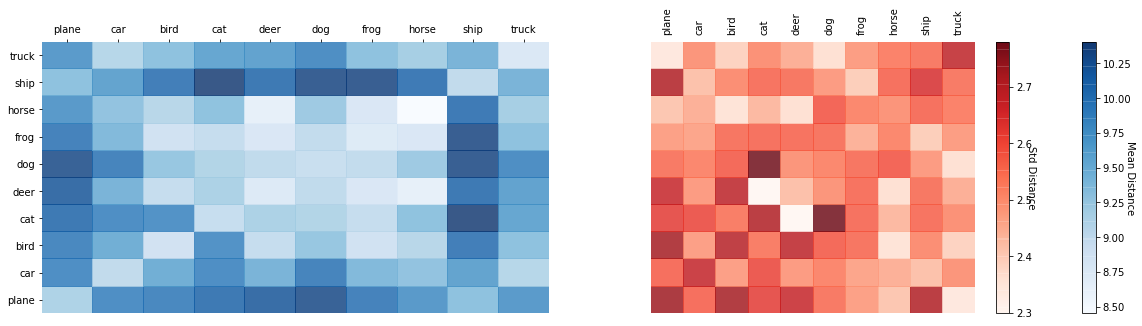

Train Epoch: 19 [0/50000 (0%)]	Loss: 1.483091
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1.100016
Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.319674
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1.422157
Train Epoch: 19 [25600/50000 (51%)]	Loss: 1.446297
Train Epoch: 19 [32000/50000 (64%)]	Loss: 1.237766
Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.034371
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.116605

Test set: Average loss: 1.5197, Accuracy: 4643/10000 (46%)



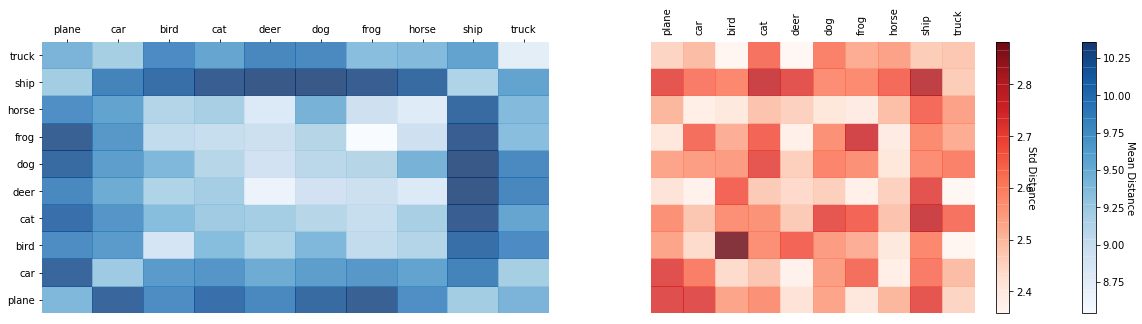

Train Epoch: 20 [0/50000 (0%)]	Loss: 1.628501
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1.401693
Train Epoch: 20 [12800/50000 (26%)]	Loss: 2.358889
Train Epoch: 20 [19200/50000 (38%)]	Loss: 1.538197
Train Epoch: 20 [25600/50000 (51%)]	Loss: 1.079850
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1.043057
Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.003076
Train Epoch: 20 [44800/50000 (90%)]	Loss: 0.681053

Test set: Average loss: 1.5327, Accuracy: 4604/10000 (46%)



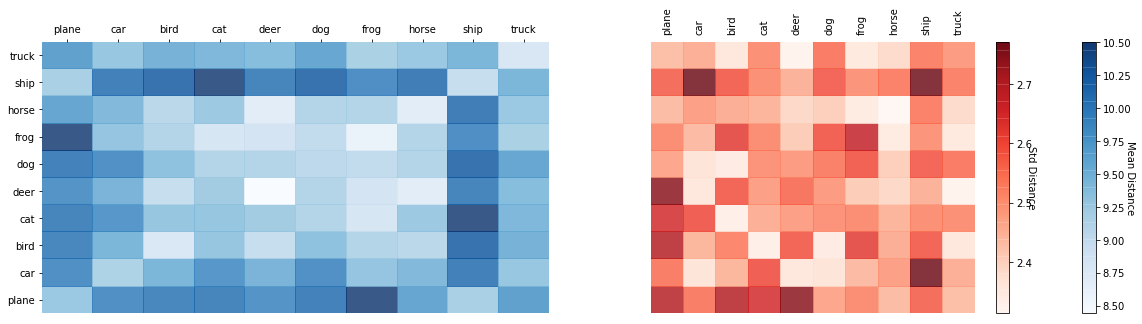

In [184]:
activation_metrics()

for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)
    activation_metrics()